Let's create an ML model that distinguishes indoor bouldering walls from outdoor bouldering walls

In [1]:
%pip install -Uqq fastai duckduckgo_search

Note: you may need to restart the kernel to use updated packages.


# 1. Experimenting

In [2]:
from duckduckgo_search import DDGS 
from fastcore.all import *
from typing import List

def search_images(keywords, max_images=200) -> List[str]:
    """
    returns a list of urls to images
    """
    return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

In [30]:
urls = search_images('pokemon', max_images=1)
urls[0]

'https://cdn.vox-cdn.com/thumbor/QIQOM2GPYSvWa-wZ30hJQWh95R8=/0x0:2040x1360/1520x1013/filters:focal(857x517:1183x843)/cdn.vox-cdn.com/uploads/chorus_image/image/71393382/jlee_220920_1001_pkmnscvi_dex.0.jpg'

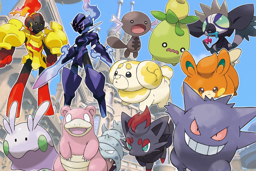

In [31]:
from fastdownload import download_url
dest = 'img/pokemon.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

These are pokemon

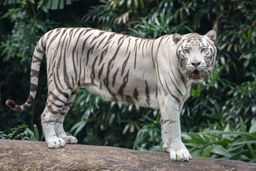

In [33]:
urls = search_images('animal', max_images=1)

dest = 'img/animal.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256,256)

These are animals

# 2. Gathering photos

In [40]:
from time import sleep

searches = ['pokemon animal','animal']
path = Path('pokemon_or_animal')

for search_word in searches:
    dest = (path/search_word)
    dest.mkdir(exist_ok=True, parents=True)
    
    download_images(dest, urls=search_images(f'{search_word} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{search_word} bright photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{search_word} shade photo'))
    
    resize_images(path/search_word, max_size=400, dest=path/search_word)

/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


clean the photos you've downloaded. Some of them may be invalid so we need to remove them or else the model may fail

In [41]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
f"{len(failed)} photos are invalid"

'88 photos are invalid'

# 3. Training the model

Setup the data that we will use to train/validate the model

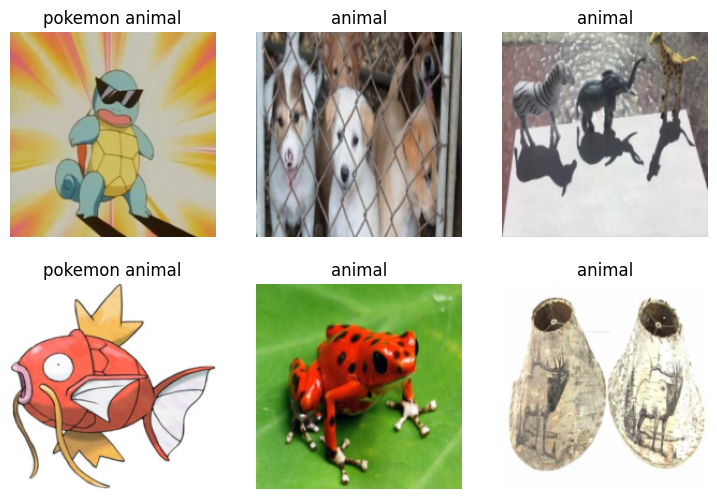

In [46]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

Here is what the code above means:

blocks=(ImageBlock, CategoryBlock),
- The inputs to our model are images, and the outputs are categories (in this case, "indoor" or "outdoor").

get_items=get_image_files, 
- To find all the inputs to our model, run the get_image_files function (which returns a list of all image files in a path).

splitter=RandomSplitter(valid_pct=0.2, seed=42),
- Split the data into training and validation sets randomly, using 20% of the data for the validation set.

get_y=parent_label,
- The labels (y values) is the name of the parent of each file (i.e. the name of the folder they're in, which will be bird or forest).

item_tfms=[Resize(192, method='squish')]
- Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).
- this is because most models require us to have the input be the same sized images

dataloaders
- Creates an object instance of dataloaders which are the things that pytorch iterates through
- Each iteration is called a batch
- pytorch iterates through batches quickly by using a GPU
- A GPU can do multiple things at the same time. That is why each batch contains multiple images, thus to process multiple images in the GPU per batch.

dls
- an object containing dataloaders
- contains iterators that pytorch uses to get batches of randomly split out training images to train the model and validation images to validate the model

show_batch
- Show me a batch of the data that fastai would want to feed into the model
- Shows you pairs of input and label

### Data Block vs Data Loaders

Data blocks are an intermediary step towards creating data loaders. This makes data blocks a more flexible approach for creating data used for creating models. However, for more common data, there are already pre-built data loaders so we do not have to go through the data block step. An example of this is the data loader for image segmentation and tabular analysis.

Now we're ready to train our model with the data we have. The fastest widely used pre-trained computer vision model is resnet18. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

fastai comes with a helpful fine_tune() method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

There are a reasonably small number of pre-trained models that apply to almost all practical scenarios.
fastai will create the right model for you (most of the time) from the pre-trained model.

In [48]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.964262,0.822333,0.250000,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.391199,0.438173,0.147436,00:05
1,0.285559,0.257289,0.096154,00:05
2,0.217094,0.215614,0.070513,00:05
3,0.164054,0.226077,0.076923,00:05
4,0.128265,0.194559,0.070513,00:05
5,0.101439,0.206548,0.083333,00:05
6,0.083533,0.201077,0.076923,00:05
7,0.069517,0.207229,0.083333,00:05
8,0.059404,0.209486,0.076923,00:05
9,0.053109,0.206594,0.076923,00:05


"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the pretrained model), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in imagenet, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the free fast.ai course.

# 4. Use our model 

In [61]:
category,_,probs = learn.predict(PILImage.create('img/pokemon2.jpeg'))
print(f"This is a: {category}.")
print(f"Probability it's a pokemon: {probs[1]:.4f}")

This is a: pokemon animal.
Probability it's a pokemon: 0.9995


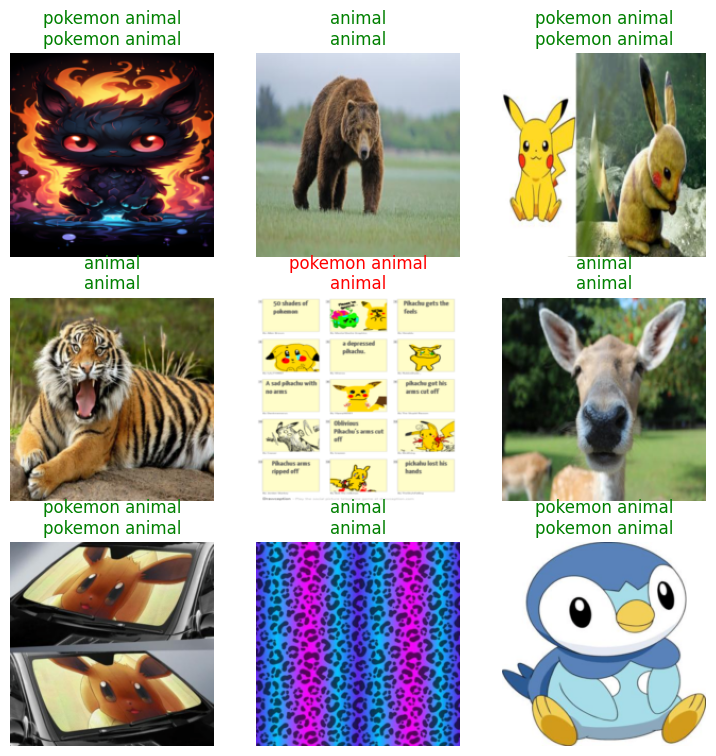

In [63]:
learn.show_results()